[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1oMC-ecMvHJ0VLOZT32woonQVsN1tBlej?usp=sharing)

# Estimating grain yield using WETF 

Here we use the temperature **Wang-Engel temperature function** with different cardinal temperature combinations with and without VPD stress function for the period from heading to maturity (grain filling period). 

Authors: 
-    **Azam Lashkari** (CIMMYT-China, azam.lashkari@jic.ac.uk)
-    **Urs Christoph Schulthess** (CIMMYT-China, U.Schulthess@cgiar.org)
-    **Ernesto Giron Echeverry** (Independent Researcher, e.giron.e@gmail.com)

Last updated: September 29, 2023


## Load libraries

In [1]:
import os, sys, gc
import pandas as pd
#import datetime as dt
pd.set_option('display.max_columns', None)

# Import Temperature Response Functions package
import tfunct
from tfunct.data import load_dataset # Function to load existing dataset
from tfunct.model import Model # Load module to create a model
from tfunct.model import tday, gpp  # Module to calculate GPP and estimated yield
from tfunct.util import figures # module to create figures

print(tfunct.__version__)

tfunct version 1.0.0


## Load Phenology, NDVI and Weather example datasets

In [2]:
%%time
# Load example dataset (Phenology, NDVI and Weather data for each site)
data = load_dataset()

CPU times: user 72.1 ms, sys: 48.1 ms, total: 120 ms
Wall time: 52.2 ms


Note: For details how to display phenology, ndvi and weather tables, please see [Getting Started](Getting_Started.ipynb)

## Create a model

The model contains all of the required functions to analyse the data

In [3]:
%%time 

# Define the Path where the output data will be stored
PATH_PRJ = '/Users/ernestogiron/Desktop/TemperatureFunctions/'
RESULTS_PATH = PATH_PRJ + 'results/'

config = {
    "PROJECT_PATH": PATH_PRJ,
    "RESULTS_PATH": RESULTS_PATH, #'./', # Results will be put in the same folder where the model is running
}

# create model to estimate grain yield
model = Model(config)
model.preprocess_raw_datasets(data) # Preprocess datasets
# Prepare dataset to run all process in parallel using NDVIA GPU if available
sites = model.prepareData()

50it [00:01, 36.45it/s]

CPU times: user 1.68 s, sys: 79.8 ms, total: 1.76 s
Wall time: 1.76 s


## Wang-Engel temperature function (WEFT)

Calculating grain yield using a simplified Arrhenius-type function, developed for responses to temperature and depending on minimum, optimum, and maximum temperatures (Wang et al., 2017)

### No stress conditions

In [4]:
%%time
WETF_noStress = model.getYield(tfun='WETF', sites=sites, is_VPDStress=False, expCSV=True)
WETF_noStress.head()

CPU times: user 705 ms, sys: 31.4 ms, total: 737 ms
Wall time: 745 ms


,UID,country,location,loc_code,cycle,ObsYield,RUE,Tmin,Topt,Tmax,TminFactor,SimYield
0,1,Nepal,Bhairahawa,BHR,2019,2.97,3.0,9.0,18.0,34.0,0.25,2.44
1,2,Pakistan,Faisalabad,FAS,2014,4.88,3.0,9.0,18.0,34.0,0.25,4.31
2,3,Pakistan,Faisalabad,FAS,2015,3.59,3.0,9.0,18.0,34.0,0.25,3.09
3,4,Pakistan,Faisalabad,FAS,2016,2.86,3.0,9.0,18.0,34.0,0.25,3.41
4,5,Pakistan,Faisalabad,FAS,2017,3.93,3.0,9.0,18.0,34.0,0.25,3.97


### Stressed VPD 

In [5]:
%%time
WETF_SFvpd = model.getYield(tfun='WETF', sites=sites, is_VPDStress=True, expCSV=True)
WETF_SFvpd.head()

CPU times: user 132 ms, sys: 3.89 ms, total: 136 ms
Wall time: 137 ms


,UID,country,location,loc_code,cycle,ObsYield,RUE,TminFactor,Tmin,Topt,Tmax,Lvpd,Uvpd,SFvpd_Lthres,SFvpd_Uthres,SimYield
0,1,Nepal,Bhairahawa,BHR,2019,2.97,3.0,9.0,18.0,34.0,0.25,1.0,4.0,0.2,1.0,1.61
1,2,Pakistan,Faisalabad,FAS,2014,4.88,3.0,9.0,18.0,34.0,0.25,1.0,4.0,0.2,1.0,3.20
2,3,Pakistan,Faisalabad,FAS,2015,3.59,3.0,9.0,18.0,34.0,0.25,1.0,4.0,0.2,1.0,2.61
3,4,Pakistan,Faisalabad,FAS,2016,2.86,3.0,9.0,18.0,34.0,0.25,1.0,4.0,0.2,1.0,2.20
4,5,Pakistan,Faisalabad,FAS,2017,3.93,3.0,9.0,18.0,34.0,0.25,1.0,4.0,0.2,1.0,2.34


### Display Grain Yield

Create a figure to compare simulated grain yield against observed. 

CPU times: user 1.14 s, sys: 135 ms, total: 1.27 s
Wall time: 766 ms


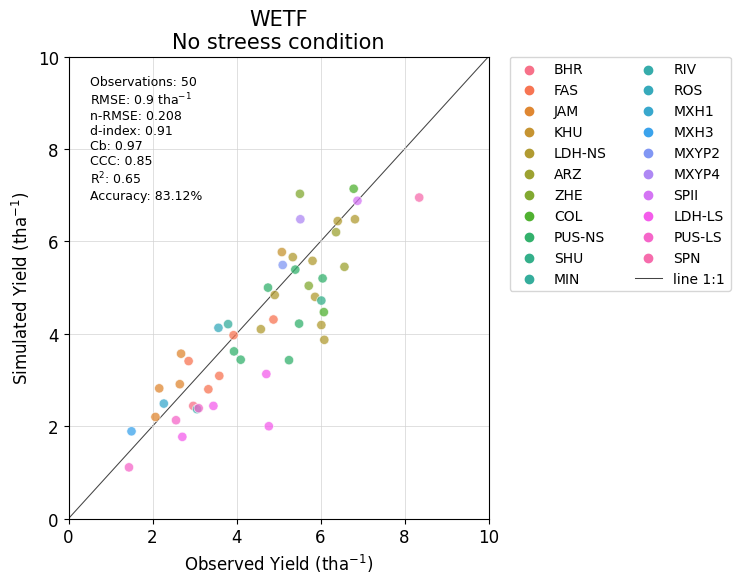

In [6]:
%%time
dirname=os.path.join(config['RESULTS_PATH'], 'WETF', 'Figures')
figures.chart_compareResults(df_result=WETF_noStress, fld1="ObsYield", fld2="SimYield", alpha=.75, s=45, xy_lim=2, hue='loc_code', 
                             loc_leg=2, ncol=2, ha='left', va='top',
                             title='WETF\nNo streess condition', #xlabel='', ylabel='', 
                             dirname=dirname, fname='WETF_noStress', 
                             dispScore=True, dispLegend=True, saveFig=True, showFig=True, fmt='jpg')


CPU times: user 877 ms, sys: 86.7 ms, total: 964 ms
Wall time: 563 ms


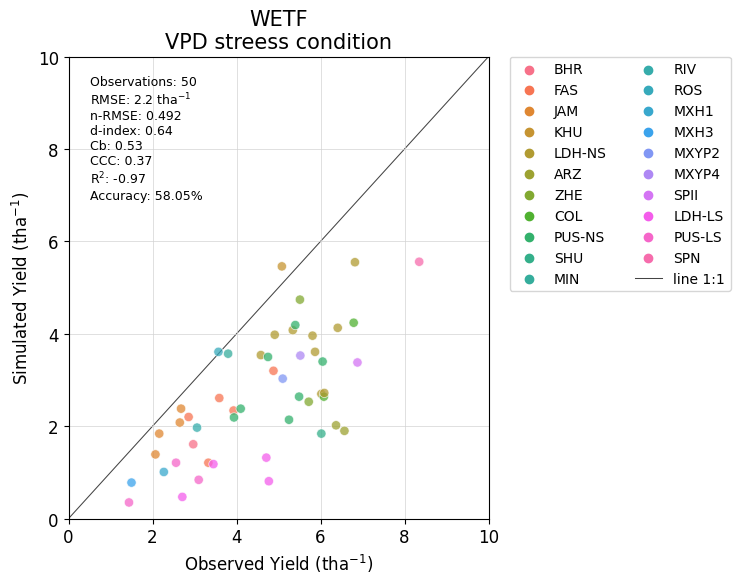

In [7]:
%%time
dirname=os.path.join(config['RESULTS_PATH'], 'WETF', 'Figures')
figures.chart_compareResults(df_result=WETF_SFvpd, fld1="ObsYield", fld2="SimYield", alpha=.75, s=45, xy_lim=2, hue='loc_code', 
                             loc_leg=2, ncol=2, ha='left', va='top',
                             title='WETF\nVPD streess condition', #xlabel='', ylabel='', 
                             dirname=dirname, fname='WETF_SFvpd', 
                             dispScore=True, dispLegend=True, saveFig=True, showFig=True, fmt='jpg')


CPU times: user 1.67 s, sys: 227 ms, total: 1.9 s
Wall time: 924 ms


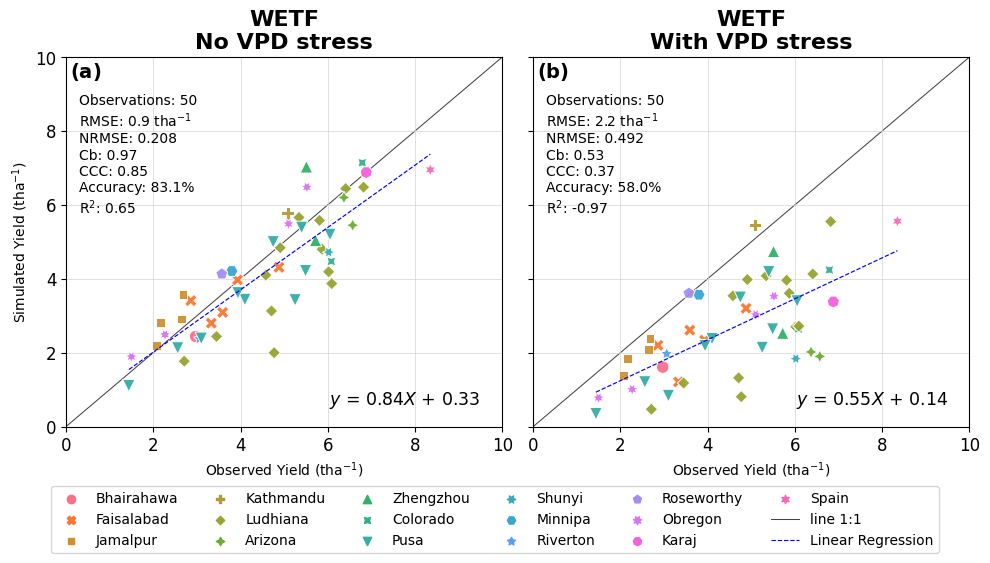

In [8]:
%%time
path_to_save_results=os.path.join(config['RESULTS_PATH'], 'WETF')
figures.plot_corrTempFunct(cmb_noStress=WETF_noStress, cmb_noStress_filtered=None, 
                           cmb_SFvpd=WETF_SFvpd, cmb_SFvpd_filtered=None,
                   functype='WETF',fld1='ObsYield',fld2='SimYield',hue='location', ncol=6, s=80, alpha=0.95, xy_lim=1, 
                   fonts_axes=10, fonts_titles=12, dispScore=True, errorbar=True, saveFig=True, showFig=True,
                   path_to_save_results=path_to_save_results, dirname='Figures', fname='Fig_1_errorbar', fmt='pdf')

## Combinations

To establish the optimum temperature response for grain-filling period, you can run several models using a wide range of cardinal temperatures. 

The optimum temperature for photosynthesis depends on the choosen temperature function.


### WETF combinations

#### No stress conditions

In [9]:
%%time

functype='WETF'
isVPDStress=False
df_GYield, data_input, cols = model.setup_dataInput_forCombinations(sites) # Setup input data
# 1) Combinations for WETF (no stress)
RUE = [3.0] #[2.8, 2.9, 3.0, 3.1, 3.2]
Tmin = [x for x in range(0, 11)]
Topt = [x for x in range(10, 26)]
Tmax = [x for x in range(30, 46)]
TminFactor = [0.25] #[0.0, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5]

# No stress conditions
array_params_to_run, array_results = model.getCombinations(functype=functype, cols=cols, RUE=RUE, 
                                                           Tmin=Tmin, Topt=Topt, Tmax=Tmax, TminFactor=TminFactor, 
                                                           isVPDStress=isVPDStress)
cmb_WETF_noStress = model.getGYield_forCombinations(functype, df_GYield, data_input, array_params_to_run, 
                                                    isVPDStress, array_results, saveFile=True)
cmb_WETF_noStress


CPU times: user 1.81 s, sys: 64.4 ms, total: 1.88 s
Wall time: 1.89 s


,UID,country,location,loc_code,cycle,ObsYield,RUE,Tmin,Topt,Tmax,TminFactor,SimYield
0,1,Nepal,Bhairahawa,BHR,2019,2.97,3.0,0.0,10.0,30.0,0.25,1.42
1,2,Pakistan,Faisalabad,FAS,2014,4.88,3.0,0.0,10.0,30.0,0.25,2.82
2,3,Pakistan,Faisalabad,FAS,2015,3.59,3.0,0.0,10.0,30.0,0.25,2.21
3,4,Pakistan,Faisalabad,FAS,2016,2.86,3.0,0.0,10.0,30.0,0.25,1.73
4,5,Pakistan,Faisalabad,FAS,2017,3.93,3.0,0.0,10.0,30.0,0.25,2.32
...,...,...,...,...,...,...,...,...,...,...,...,...
139995,46,India,Pusa,PUS-LS,2018,1.44,3.0,10.0,25.0,45.0,0.25,2.27
139996,47,India,Pusa,PUS-LS,2019,3.10,3.0,10.0,25.0,45.0,0.25,4.72
139997,48,India,Ludhiana,LDH-NS,2022,6.09,3.0,10.0,25.0,45.0,0.25,5.02
139998,49,India,Ludhiana,LDH-LS,2022,4.77,3.0,10.0,25.0,45.0,0.25,3.97


#### No stress Metrics

In [10]:
%%time

m_WETF_noStress = model.getCombinations_Metrics(functype, isVPDStress, df_GYield, 
                                                 array_params_to_run, array_results, saveFile=True) #, fmt='parquet')
m_WETF_noStress

100%|██████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:31<00:00, 88.46it/s]


CPU times: user 29.2 s, sys: 4.13 s, total: 33.3 s
Wall time: 31.7 s


,RUE,Tmin,Topt,Tmax,TminFactor,MAE,MSE,RMSE,RMSRE,MAPE,pvalue,R2,EF,intercept,slope,Cb,CCC,Accuracy
0,3.0,0.0,10.0,30.0,0.25,2.209,6.027,2.455,53.218,49.527,1.178069e-09,0.541,-1.343,-0.2075,0.5646,0.44,0.33,50.47
1,3.0,0.0,10.0,31.0,0.25,2.000,5.019,2.240,47.998,44.507,1.120526e-10,0.583,-0.951,-0.1076,0.5895,0.49,0.38,55.49
2,3.0,0.0,10.0,32.0,0.25,1.808,4.183,2.045,43.180,39.845,1.176255e-11,0.620,-0.626,-0.0046,0.6099,0.54,0.44,60.16
3,3.0,0.0,10.0,33.0,0.25,1.637,3.512,1.874,38.998,35.691,1.720306e-12,0.649,-0.365,0.0901,0.6276,0.59,0.49,64.31
4,3.0,0.0,10.0,34.0,0.25,1.483,2.971,1.724,35.400,31.970,3.164497e-13,0.673,-0.155,0.1711,0.6441,0.64,0.54,68.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2795,3.0,10.0,25.0,41.0,0.25,1.018,1.493,1.222,37.183,27.317,2.313390e-11,0.609,0.419,1.2611,0.8377,0.95,0.76,72.68
2796,3.0,10.0,25.0,42.0,0.25,1.022,1.522,1.234,37.577,27.482,2.075491e-11,0.611,0.408,1.2751,0.8409,0.95,0.75,72.52
2797,3.0,10.0,25.0,43.0,0.25,1.025,1.547,1.244,37.866,27.575,1.828027e-11,0.613,0.399,1.2800,0.8451,0.94,0.75,72.42
2798,3.0,10.0,25.0,44.0,0.25,1.029,1.570,1.253,38.130,27.698,1.598582e-11,0.615,0.390,1.2866,0.8486,0.94,0.75,72.30


#### stressed Vapor pressure deficit (VPD)

In [11]:
%%time

functype='WETF'
isVPDStress=True
df_GYield, data_input, cols = model.setup_dataInput_forCombinations(sites) # Setup input data
# Combinations
RUE = [3.0]
Tmin = [x for x in range(0, 11)]
Topt = [x for x in range(10, 26)]
Tmax = [x for x in range(30, 46)]
TminFactor = [0.25] #[0.0, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5]
Lvpd = [0.5, 1, 1.5, 2, 2.5, 3, 3.5]
Uvpd = [1, 1.5, 2, 2.5, 3, 3.5, 4]
SFvpd_Lthres = [0.2, 0.4, 0.6, 0.8] 
SFvpd_Uthres = [1]
# No stress conditions
array_params_to_run, array_results = model.getCombinations(functype=functype, cols=cols, RUE=RUE, Tmin=Tmin, Topt=Topt, 
                                                           Tmax=Tmax, TminFactor=TminFactor,  
                                                           Lvpd=Lvpd, Uvpd=Uvpd, SFvpd_Lthres=SFvpd_Lthres, SFvpd_Uthres=SFvpd_Uthres,
                                                           isVPDStress=isVPDStress)

# If combinations are not big
#cmb_WETF_SFvpd = model.getGYield_forCombinations(functype, df_GYield, data_input, array_params_to_run, 
#                                           isVPDStress, array_results, saveFile=True) # fmt='parquet' #csv
# cmb_WETF_SFvpd

# Use returnDF=False when the number of combinations is too large. 
# This avoid memory issues and save the file in parquet format by default
model.getGYield_forCombinations(functype, df_GYield, data_input, array_params_to_run, 
                                           isVPDStress, array_results, saveFile=True, returnDF=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:51<00:00, 12.87s/it]


  created_by: parquet-cpp-arrow version 13.0.0
  num_columns: 16
  num_rows: 15680000
  num_row_groups: 15
  format_version: 2.6
  serialized_size: 26771
CPU times: user 1min 36s, sys: 4.82 s, total: 1min 40s
Wall time: 1min 40s


In [12]:
%%time

m_WETF_SFvpd = model.getCombinations_Metrics(functype, isVPDStress, df_GYield, 
                                             array_params_to_run, array_results, saveFile=True)
m_WETF_SFvpd

100%|████████████████████████████████████████████████████████████████████████████████████| 313600/313600 [03:41<00:00, 1417.75it/s]


CPU times: user 3min 2s, sys: 4min 50s, total: 7min 53s
Wall time: 3min 42s


,RUE,Tmin,Topt,Tmax,TminFactor,Lvpd,Uvpd,SFvpd_Lthres,SFvpd_Uthres,MAE,MSE,RMSE,RMSRE,MAPE,pvalue,R2,EF,intercept,slope,Cb,CCC,Accuracy
0,3.0,0.0,10.0,30.0,0.25,0.5,1.0,0.2,1.0,3.906,17.421,4.174,86.331,85.462,3.508411e-03,0.164,-5.772,0.0504,0.1357,0.09,0.04,14.54
1,3.0,0.0,10.0,30.0,0.25,0.5,1.0,0.4,1.0,3.477,13.881,3.726,77.604,76.364,1.515715e-05,0.326,-4.396,-0.0119,0.2429,0.14,0.08,23.64
2,3.0,0.0,10.0,30.0,0.25,0.5,1.0,0.6,1.0,3.047,10.786,3.284,69.057,67.227,2.315268e-07,0.430,-3.193,-0.0752,0.3508,0.22,0.15,32.77
3,3.0,0.0,10.0,30.0,0.25,0.5,1.0,0.8,1.0,2.618,8.164,2.857,60.872,58.133,1.333554e-08,0.493,-2.174,-0.1387,0.4584,0.32,0.23,41.87
4,3.0,0.0,10.0,30.0,0.25,0.5,1.5,0.2,1.0,3.607,15.231,3.903,81.541,79.345,4.124084e-03,0.159,-4.921,-0.0362,0.2200,0.17,0.07,20.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313595,3.0,10.0,25.0,45.0,0.25,3.0,4.0,0.8,1.0,0.794,0.982,0.991,26.625,19.960,1.165974e-12,0.655,0.618,0.9204,0.7447,0.98,0.81,80.04
313596,3.0,10.0,25.0,45.0,0.25,3.5,4.0,0.2,1.0,0.848,1.230,1.109,28.123,20.807,1.868092e-10,0.574,0.522,1.0827,0.7203,0.99,0.77,79.19
313597,3.0,10.0,25.0,45.0,0.25,3.5,4.0,0.4,1.0,0.782,0.994,0.997,27.221,19.892,4.206708e-12,0.636,0.614,1.0721,0.7466,1.00,0.81,80.11
313598,3.0,10.0,25.0,45.0,0.25,3.5,4.0,0.6,1.0,0.732,0.889,0.943,27.375,19.337,3.777573e-13,0.670,0.655,1.0635,0.7723,1.00,0.83,80.66


### Display grain yield comparison with and without VPD stress

In [13]:
%%time
# If the process above used "returnDF=False", it's necessary to load the data to create figures
# path of the combinations and metrics files
c_WETF = os.path.join(config['RESULTS_PATH'], "WETF", "WETF_noStress", "combinations_Yield_WETF_noStress.parquet")
#m_WETF = os.path.join(config['RESULTS_PATH'], "WETF", "WETF_noStress", "metrics_Yield_WETF_noStress.parquet")
c_WETF_SFvpd = os.path.join(config['RESULTS_PATH'], "WETF", "WETF_SFvpd", "combinations_Yield_WETF_SFvpd.parquet")
#m_WETF_SFvpd = os.path.join(config['RESULTS_PATH'], "WETF", "WETF_SFvpd", "metrics_Yield_WETF_SFvpd.parquet")

cmb_WETF_noStress = pd.read_parquet(c_WETF)
cmb_WETF_SFvpd = pd.read_parquet(c_WETF_SFvpd)
#m_WETF_noStress = pd.read_parquet(m_WETF)
#m_WETF_SFvpd = pd.read_parquet(m_WETF_SFvpd)

CPU times: user 3.96 s, sys: 1.54 s, total: 5.5 s
Wall time: 1.59 s


CPU times: user 7min 45s, sys: 39.5 s, total: 8min 24s
Wall time: 8min 29s


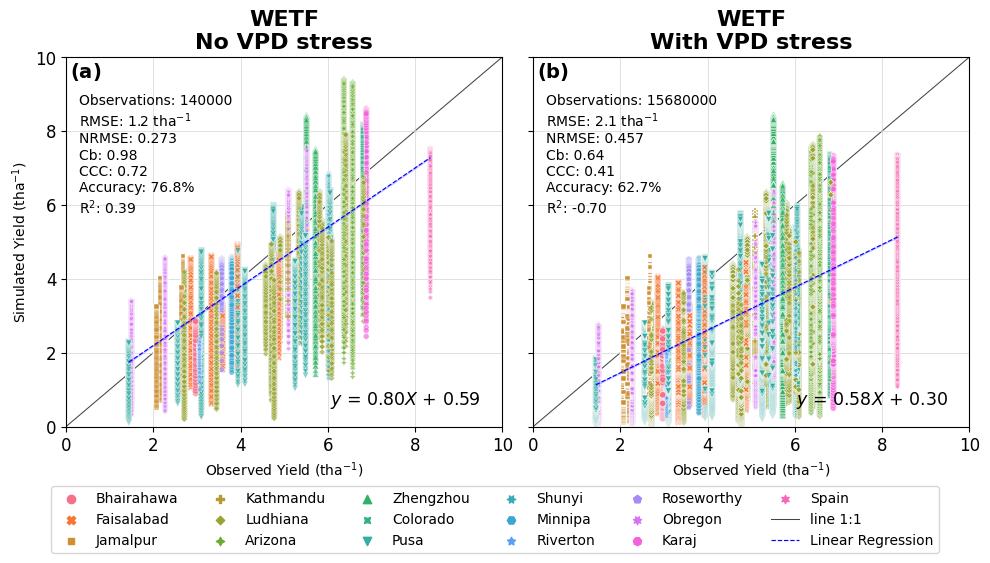

In [14]:
%%time
path_to_save_results=os.path.join(config['RESULTS_PATH'], 'WETF')
figures.plot_corrTempFunct(cmb_noStress=cmb_WETF_noStress, cmb_noStress_filtered=cmb_WETF_noStress, 
                   cmb_SFvpd=cmb_WETF_SFvpd, cmb_SFvpd_filtered=cmb_WETF_SFvpd,
                   functype='WETF',fld1='ObsYield',fld2='SimYield',hue='location', ncol=6, s=20, alpha=0.65, xy_lim=1, 
                   fonts_axes=10, fonts_titles=12, dispScore=True, errorbar=False, saveFig=True, showFig=True,
                   path_to_save_results=path_to_save_results, dirname='Figures', fname='Fig_2_nofilters', fmt='jpg')

CPU times: user 4.35 s, sys: 1.87 s, total: 6.22 s
Wall time: 6.53 s


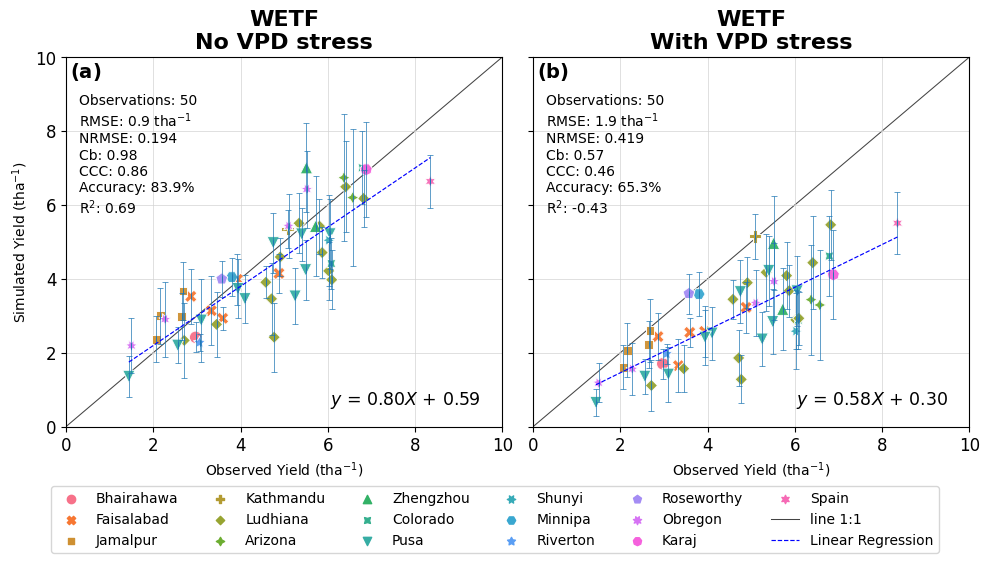

In [15]:
%%time
path_to_save_results=os.path.join(config['RESULTS_PATH'], 'WETF')
figures.plot_corrTempFunct(cmb_noStress=cmb_WETF_noStress, cmb_noStress_filtered=cmb_WETF_noStress, 
                   cmb_SFvpd=cmb_WETF_SFvpd, cmb_SFvpd_filtered=cmb_WETF_SFvpd,
                   functype='WETF',fld1='ObsYield',fld2='SimYield',hue='location', ncol=6, s=80, alpha=0.95, xy_lim=1, 
                   fonts_axes=10, fonts_titles=12, dispScore=True, errorbar=True, saveFig=True, showFig=True,
                   path_to_save_results=path_to_save_results, dirname='Figures', fname='Fig_2_nofilters_errorbar', fmt='jpg')

## Select the best results using filters

After running several models you can filter results to see which one look better. 

The following table is an example of one filter used to evaluate the best models, it only use three (3) evaluation metrics (_Cb, CCC, and RMSRE_) to select the top ones. 

| Temperature Function | Cb  | CCC  |  RMSRE |   |
|---------------------|---|---|---|---|
| **WETF** |  0.98 |  > 0.8 |   |   |
| **WETF vpd stress**|  0.98 | > 0.8  | < 21.5  |   |


In [16]:
# Load module to filter combinations in an easy way
from tfunct.util import filterSimulations


#### filter WETF manually

In [17]:
m_WETF_noStress[
    (m_WETF_noStress['Cb']>0.98) & (m_WETF_noStress['CCC']>0.8) 
]

,RUE,Tmin,Topt,Tmax,TminFactor,MAE,MSE,RMSE,RMSRE,MAPE,pvalue,R2,EF,intercept,slope,Cb,CCC,Accuracy
47,3.0,0.0,12.0,45.0,0.25,0.685,0.758,0.870,20.831,16.315,3.938543e-15,0.727,0.705,0.7616,0.7890,0.99,0.86,83.69
60,3.0,0.0,13.0,42.0,0.25,0.675,0.756,0.869,20.391,15.917,2.594596e-15,0.732,0.706,0.7061,0.7966,0.99,0.86,84.08
61,3.0,0.0,13.0,43.0,0.25,0.680,0.742,0.862,20.766,16.230,3.112351e-15,0.730,0.711,0.7422,0.8007,0.99,0.86,83.77
62,3.0,0.0,13.0,44.0,0.25,0.691,0.734,0.856,21.170,16.657,3.423187e-15,0.729,0.715,0.7714,0.8053,1.00,0.87,83.34
63,3.0,0.0,13.0,45.0,0.25,0.701,0.734,0.857,21.662,17.059,4.302333e-15,0.726,0.715,0.8043,0.8082,1.00,0.87,82.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2757,3.0,10.0,23.0,35.0,0.25,0.800,0.983,0.991,28.038,20.535,9.372771e-14,0.689,0.618,0.8517,0.8682,0.99,0.84,79.47
2770,3.0,10.0,24.0,32.0,0.25,0.831,1.064,1.031,26.642,20.439,2.822672e-12,0.642,0.586,0.6981,0.8137,1.00,0.81,79.56
2771,3.0,10.0,24.0,33.0,0.25,0.830,1.032,1.016,27.790,21.001,2.014616e-12,0.647,0.599,0.8318,0.8222,1.00,0.82,79.00
2772,3.0,10.0,24.0,34.0,0.25,0.850,1.058,1.029,29.220,21.840,1.777281e-12,0.649,0.589,0.9223,0.8310,1.00,0.82,78.16


In [18]:
m_WETF_SFvpd[(m_WETF_SFvpd['Cb']>0.98) & (m_WETF_SFvpd['CCC']>0.80) & (m_WETF_SFvpd['RMSRE']<21.5)]

,RUE,Tmin,Topt,Tmax,TminFactor,Lvpd,Uvpd,SFvpd_Lthres,SFvpd_Uthres,MAE,MSE,RMSE,RMSRE,MAPE,pvalue,R2,EF,intercept,slope,Cb,CCC,Accuracy
12423,3.0,0.0,16.0,44.0,0.25,3.0,3.5,0.8,1.0,0.698,0.774,0.880,21.357,16.852,5.329494e-15,0.724,0.699,0.7716,0.7822,0.99,0.86,83.15
12535,3.0,0.0,16.0,45.0,0.25,3.0,3.5,0.8,1.0,0.686,0.758,0.871,21.464,16.678,4.731750e-15,0.725,0.705,0.7949,0.7837,0.99,0.86,83.32
13879,3.0,0.0,17.0,41.0,0.25,3.0,3.5,0.8,1.0,0.707,0.789,0.888,21.337,17.028,6.489510e-15,0.721,0.693,0.7306,0.7891,0.99,0.85,82.97
13991,3.0,0.0,17.0,42.0,0.25,3.0,3.5,0.8,1.0,0.695,0.768,0.876,21.469,16.866,5.550869e-15,0.723,0.701,0.7606,0.7905,0.99,0.86,83.13
15447,3.0,0.0,18.0,39.0,0.25,3.0,3.5,0.8,1.0,0.712,0.795,0.892,21.485,17.169,7.755483e-15,0.719,0.691,0.7027,0.7974,0.99,0.85,82.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302279,3.0,10.0,19.0,40.0,0.25,3.0,3.5,0.8,1.0,0.702,0.789,0.888,21.308,16.894,4.997434e-15,0.724,0.693,0.6660,0.8019,0.99,0.86,83.11
302391,3.0,10.0,19.0,41.0,0.25,3.0,3.5,0.8,1.0,0.690,0.767,0.876,21.392,16.720,4.255964e-15,0.726,0.702,0.7000,0.8024,0.99,0.86,83.28
304283,3.0,10.0,20.0,42.0,0.25,2.5,3.0,0.8,1.0,0.665,0.769,0.877,21.273,16.188,2.705716e-15,0.731,0.701,0.6652,0.8010,0.99,0.86,83.81
304395,3.0,10.0,20.0,43.0,0.25,2.5,3.0,0.8,1.0,0.662,0.758,0.871,21.408,16.176,2.730790e-15,0.731,0.705,0.6876,0.8014,0.99,0.86,83.82


**It's clear that these thresholds still show so many solutions. Let's try to improve the filters. For example using `Cb = 1.0` and `CCC >= 0.88` and `Accuracy >= 84%` and `RMSRE <= 20.4`.**

In [19]:
m_WETF_noStress[
    (m_WETF_noStress['Cb']==1.0) & (m_WETF_noStress['CCC']>=0.88) 
    & (m_WETF_noStress['Accuracy']>=84) & (m_WETF_noStress['RMSRE'] <= 20.4) 
]

,RUE,Tmin,Topt,Tmax,TminFactor,MAE,MSE,RMSE,RMSRE,MAPE,pvalue,R2,EF,intercept,slope,Cb,CCC,Accuracy
2425,3.0,9.0,17.0,39.0,0.25,0.662,0.717,0.847,20.317,15.750,1.266149e-15,0.739,0.721,0.6236,0.8404,1.0,0.88,84.25
2439,3.0,9.0,18.0,37.0,0.25,0.667,0.719,0.848,20.323,15.890,1.057484e-15,0.741,0.721,0.5713,0.8565,1.0,0.88,84.11
2679,3.0,10.0,18.0,37.0,0.25,0.668,0.722,0.850,20.074,15.852,9.833239e-16,0.742,0.719,0.5450,0.8536,1.0,0.88,84.15


In [20]:
m_WETF_SFvpd[
    (m_WETF_SFvpd['Cb']==1.00) & (m_WETF_SFvpd['CCC']>=0.8) 
    & (m_WETF_SFvpd['Accuracy']>=83) & (m_WETF_SFvpd['RMSRE'] <= 21.85) 
]

,RUE,Tmin,Topt,Tmax,TminFactor,Lvpd,Uvpd,SFvpd_Lthres,SFvpd_Uthres,MAE,MSE,RMSE,RMSRE,MAPE,pvalue,R2,EF,intercept,slope,Cb,CCC,Accuracy
189495,3.0,6.0,19.0,41.0,0.25,3.0,3.5,0.8,1.0,0.679,0.743,0.862,21.825,16.692,4.293063e-15,0.726,0.711,0.7679,0.8046,1.0,0.87,83.31
275735,3.0,9.0,19.0,43.0,0.25,3.0,3.5,0.8,1.0,0.670,0.730,0.855,21.781,16.489,3.147023e-15,0.729,0.716,0.7732,0.8048,1.0,0.87,83.51
302727,3.0,10.0,19.0,44.0,0.25,3.0,3.5,0.8,1.0,0.667,0.729,0.854,21.810,16.448,3.041049e-15,0.730,0.717,0.7756,0.8049,1.0,0.87,83.55


### No stress conditions

Loading combinations...
Loading metrics...
2800 combinations found
3 combinations found after applied filter
Filtered data set saved at /Users/ernestogiron/Desktop/TemperatureFunctions/results/WETF/WETF_filtered/filtered_metrics_combinations_Yield_WETF_noStress_20231001.parquet
CPU times: user 1.7 s, sys: 462 ms, total: 2.16 s
Wall time: 1.52 s


,UID,country,location,loc_code,cycle,ObsYield,RUE,Tmin,Topt,Tmax,TminFactor,SimYield,MAE,MSE,RMSE,RMSRE,MAPE,pvalue,R2,EF,intercept,slope,Cb,CCC,Accuracy
0,1,Nepal,Bhairahawa,BHR,2019,2.97,3.0,9.0,17.0,39.0,0.25,2.51,0.662,0.717,0.847,20.317,15.750,1.266149e-15,0.739,0.721,0.6236,0.8404,1.0,0.88,84.25
1,2,Pakistan,Faisalabad,FAS,2014,4.88,3.0,9.0,17.0,39.0,0.25,4.35,0.662,0.717,0.847,20.317,15.750,1.266149e-15,0.739,0.721,0.6236,0.8404,1.0,0.88,84.25
2,3,Pakistan,Faisalabad,FAS,2015,3.59,3.0,9.0,17.0,39.0,0.25,3.13,0.662,0.717,0.847,20.317,15.750,1.266149e-15,0.739,0.721,0.6236,0.8404,1.0,0.88,84.25
3,4,Pakistan,Faisalabad,FAS,2016,2.86,3.0,9.0,17.0,39.0,0.25,3.67,0.662,0.717,0.847,20.317,15.750,1.266149e-15,0.739,0.721,0.6236,0.8404,1.0,0.88,84.25
4,5,Pakistan,Faisalabad,FAS,2017,3.93,3.0,9.0,17.0,39.0,0.25,4.21,0.662,0.717,0.847,20.317,15.750,1.266149e-15,0.739,0.721,0.6236,0.8404,1.0,0.88,84.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,46,India,Pusa,PUS-LS,2018,1.44,3.0,10.0,18.0,37.0,0.25,1.39,0.668,0.722,0.850,20.074,15.852,9.833239e-16,0.742,0.719,0.5450,0.8536,1.0,0.88,84.15
146,47,India,Pusa,PUS-LS,2019,3.10,3.0,10.0,18.0,37.0,0.25,2.95,0.668,0.722,0.850,20.074,15.852,9.833239e-16,0.742,0.719,0.5450,0.8536,1.0,0.88,84.15
147,48,India,Ludhiana,LDH-NS,2022,6.09,3.0,10.0,18.0,37.0,0.25,4.16,0.668,0.722,0.850,20.074,15.852,9.833239e-16,0.742,0.719,0.5450,0.8536,1.0,0.88,84.15
148,49,India,Ludhiana,LDH-LS,2022,4.77,3.0,10.0,18.0,37.0,0.25,2.47,0.668,0.722,0.850,20.074,15.852,9.833239e-16,0.742,0.719,0.5450,0.8536,1.0,0.88,84.15


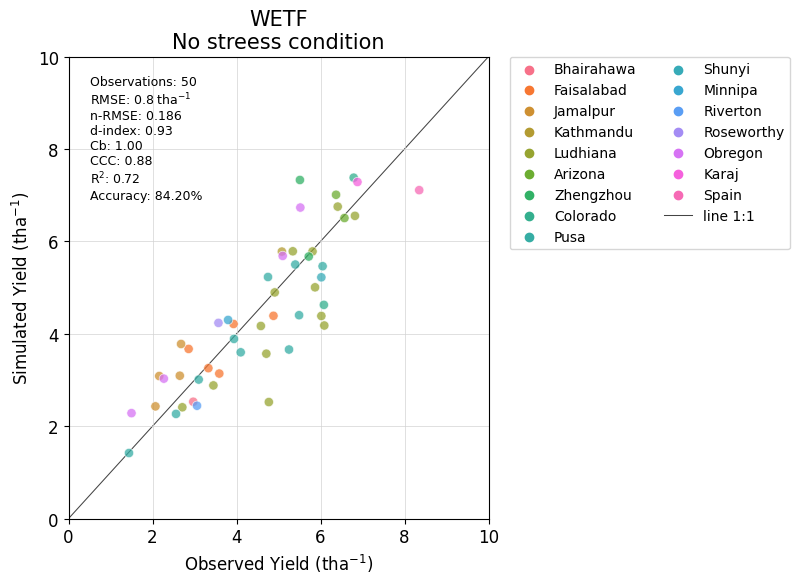

In [21]:
%%time
# path of the combinations and metrics files
c_WETF = os.path.join(config['RESULTS_PATH'], "WETF", "WETF_noStress", "combinations_Yield_WETF_noStress.parquet")
m_WETF = os.path.join(config['RESULTS_PATH'], "WETF", "WETF_noStress", "metrics_Yield_WETF_noStress.parquet")

# Filters
cmb_filters = dict(
                RUE = ('RUE', '=', 3.0 ),
                TminFactor = ('TminFactor', '=', 0.25 )
            )
met_filters = dict(
        Cb = ('>=', 1.00),
        CCC = ('>=', 0.88),
        Accuracy = ('>=', 84),
        RMSRE = ('<=', 20.4),
    )
outputPath = os.path.join(config['RESULTS_PATH'], "WETF")

# Use pdFormat=True to display filtered table. Use when the results are small to avoid freeze you computer session
# Use fmt='parquet' and avoid fmt='csv' when the results are quite large.
# Use dispFig=True if the filtered table is small.
filtered_c_WETF = filterSimulations(functype='WETF', VPDstress=False, cmb=c_WETF, met=m_WETF, 
                                 cmb_filters=cmb_filters, met_filters=met_filters, pdFormat=True, 
                                 dispFig=True, saveFig=True, figname='Fig_topComb_avgYield', figfmt='pdf',
                                 saveResults=True, outputPath=outputPath, fmt='parquet')

filtered_c_WETF

### VPD stress conditions

Loading combinations...
Loading metrics...
313600 combinations found
3 combinations found after applied filter
Filtered data set saved at /Users/ernestogiron/Desktop/TemperatureFunctions/results/WETF/WETF_filtered/filtered_metrics_combinations_Yield_WETF_SFvpd_20231001.parquet
CPU times: user 9.75 s, sys: 5.87 s, total: 15.6 s
Wall time: 4.59 s


,UID,country,location,loc_code,cycle,ObsYield,RUE,Tmin,Topt,Tmax,TminFactor,Lvpd,Uvpd,SFvpd_Lthres,SFvpd_Uthres,SimYield,MAE,MSE,RMSE,RMSRE,MAPE,pvalue,R2,EF,intercept,slope,Cb,CCC,Accuracy
0,1,Nepal,Bhairahawa,BHR,2019,2.97,3.0,6.0,19.0,41.0,0.25,3.0,3.5,0.8,1.0,2.50,0.679,0.743,0.862,21.825,16.692,4.293063e-15,0.726,0.711,0.7679,0.8046,1.0,0.87,83.31
1,2,Pakistan,Faisalabad,FAS,2014,4.88,3.0,6.0,19.0,41.0,0.25,3.0,3.5,0.8,1.0,4.55,0.679,0.743,0.862,21.825,16.692,4.293063e-15,0.726,0.711,0.7679,0.8046,1.0,0.87,83.31
2,3,Pakistan,Faisalabad,FAS,2015,3.59,3.0,6.0,19.0,41.0,0.25,3.0,3.5,0.8,1.0,3.24,0.679,0.743,0.862,21.825,16.692,4.293063e-15,0.726,0.711,0.7679,0.8046,1.0,0.87,83.31
3,4,Pakistan,Faisalabad,FAS,2016,2.86,3.0,6.0,19.0,41.0,0.25,3.0,3.5,0.8,1.0,3.54,0.679,0.743,0.862,21.825,16.692,4.293063e-15,0.726,0.711,0.7679,0.8046,1.0,0.87,83.31
4,5,Pakistan,Faisalabad,FAS,2017,3.93,3.0,6.0,19.0,41.0,0.25,3.0,3.5,0.8,1.0,4.18,0.679,0.743,0.862,21.825,16.692,4.293063e-15,0.726,0.711,0.7679,0.8046,1.0,0.87,83.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,46,India,Pusa,PUS-LS,2018,1.44,3.0,10.0,19.0,44.0,0.25,3.0,3.5,0.8,1.0,1.45,0.667,0.729,0.854,21.810,16.448,3.041049e-15,0.730,0.717,0.7756,0.8049,1.0,0.87,83.55
146,47,India,Pusa,PUS-LS,2019,3.10,3.0,10.0,19.0,44.0,0.25,3.0,3.5,0.8,1.0,2.67,0.667,0.729,0.854,21.810,16.448,3.041049e-15,0.730,0.717,0.7756,0.8049,1.0,0.87,83.55
147,48,India,Ludhiana,LDH-NS,2022,6.09,3.0,10.0,19.0,44.0,0.25,3.0,3.5,0.8,1.0,4.40,0.667,0.729,0.854,21.810,16.448,3.041049e-15,0.730,0.717,0.7756,0.8049,1.0,0.87,83.55
148,49,India,Ludhiana,LDH-LS,2022,4.77,3.0,10.0,19.0,44.0,0.25,3.0,3.5,0.8,1.0,2.69,0.667,0.729,0.854,21.810,16.448,3.041049e-15,0.730,0.717,0.7756,0.8049,1.0,0.87,83.55


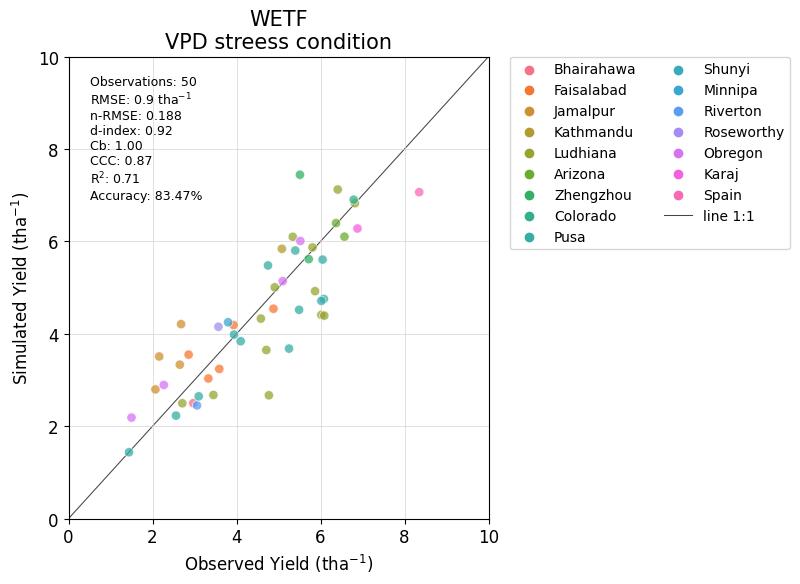

In [22]:
%%time

# Path of the combinations and metrics files
c_WETF_SFvpd = os.path.join(config['RESULTS_PATH'], "WETF", "WETF_SFvpd", "combinations_Yield_WETF_SFvpd.parquet")
m_WETF_SFvpd = os.path.join(config['RESULTS_PATH'], "WETF", "WETF_SFvpd", "metrics_Yield_WETF_SFvpd.parquet")

cmb_filters = dict(
                RUE = ('RUE', '=', 3.0 ),
                TminFactor = ('TminFactor', '=', 0.25 )
            )
met_filters = dict(
        Cb = ('>=', 1.00),
        CCC = ('>=', 0.8),
        Accuracy = ('>=', 83),
        RMSRE = ('<=', 21.85),
    )
outputPath = os.path.join(config['RESULTS_PATH'], "WETF") 

# Use pdFormat=True to display filtered table. Use when the results are small to avoid freeze you computer session
# Use fmt='parquet' and avoid fmt='csv' when the results are quite large.
# Use dispFig=True if the filtered table is small.
filtered_c_WETF_SFvpd = filterSimulations(functype='WETF', VPDstress=True, cmb=c_WETF_SFvpd, met=m_WETF_SFvpd, 
                                 cmb_filters=cmb_filters, met_filters=met_filters, pdFormat=True, 
                                 dispFig=True, saveFig=True, figname='Fig_topComb_avgYield', figfmt='pdf',
                                 saveResults=True, outputPath=outputPath, fmt='parquet')

filtered_c_WETF_SFvpd

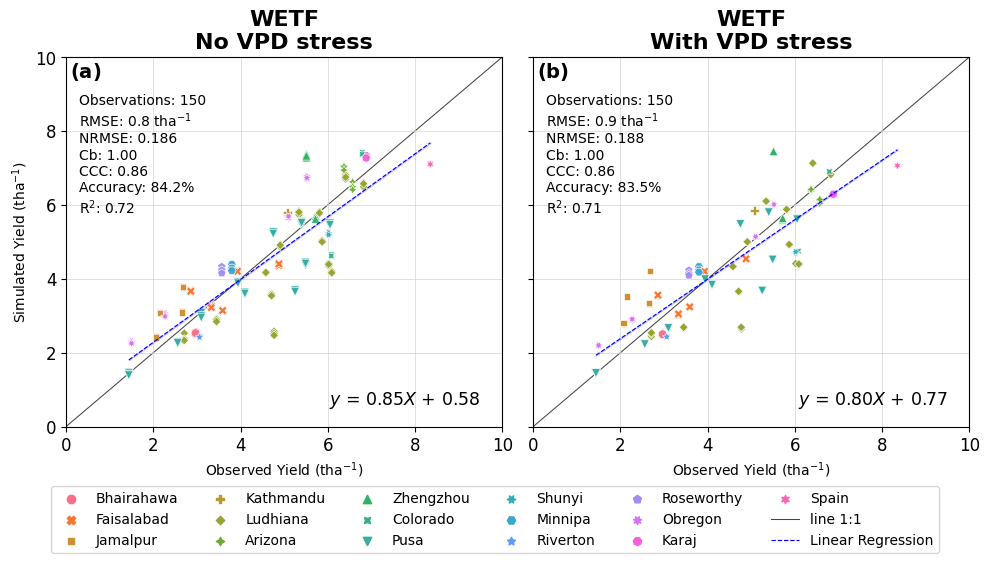

In [23]:
path_to_save_results=os.path.join(config['RESULTS_PATH'],'WETF', 'WETF_filtered')
figures.plot_corrTempFunct(cmb_noStress=filtered_c_WETF, cmb_noStress_filtered=filtered_c_WETF, 
                           cmb_SFvpd=filtered_c_WETF_SFvpd, cmb_SFvpd_filtered=filtered_c_WETF_SFvpd,
                   functype='WETF',fld1='ObsYield',fld2='SimYield',hue='location', ncol=6, s=40, alpha=0.95, xy_lim=1, 
                   fonts_axes=10, fonts_titles=12, dispScore=True, errorbar=False, saveFig=True, showFig=True,
                   path_to_save_results=path_to_save_results, dirname='Figures', fname='Fig_2_filtered', fmt='jpg')

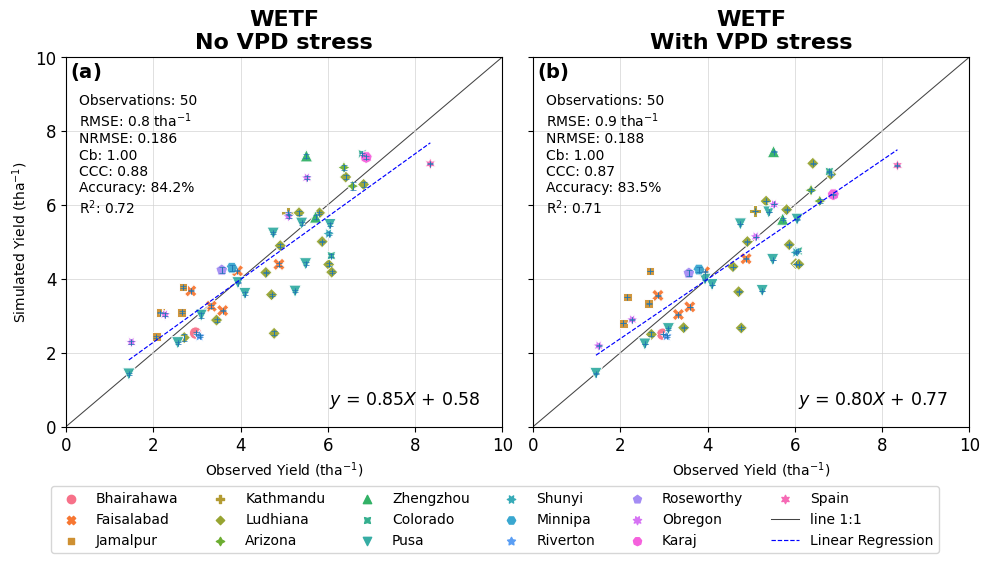

In [24]:
path_to_save_results=os.path.join(config['RESULTS_PATH'], 'WETF', 'WETF_filtered')
figures.plot_corrTempFunct(cmb_noStress=filtered_c_WETF, cmb_noStress_filtered=filtered_c_WETF, 
                           cmb_SFvpd=filtered_c_WETF_SFvpd, cmb_SFvpd_filtered=filtered_c_WETF_SFvpd,
                   functype='WETF',fld1='ObsYield',fld2='SimYield',hue='location', ncol=6, s=80, alpha=0.95, xy_lim=1, 
                   fonts_axes=10, fonts_titles=12, dispScore=True, errorbar=True, saveFig=True, showFig=True,
                   path_to_save_results=path_to_save_results, dirname='Figures', fname='Fig_2_filtered_errorbar', fmt='jpg')

# Comparison of the best combinations

In [25]:
%%time
# Prepare data as a input for create comparison figures by site and/or best combinations
path_to_save_results=os.path.join(config['RESULTS_PATH'], 'WETF', 'WETF_filtered')
df_TDays_vs_TempResponse, df_TDays_vs_TempResponse_mean_allSites = \
figures.createFigure_Type_II_WETF(sites, cmb=filtered_c_WETF, roundVal=3, maxTDay=40, saveTable=True,
                        path_to_save_results=path_to_save_results, fmt='parquet')
df_TDays_vs_TempResponse.head()

Calculating average value for all simulations...
CPU times: user 4.45 s, sys: 344 ms, total: 4.8 s
Wall time: 5.11 s


,TDay,TempResponse,UID,country,location,loc_code,cycle,RUE,TminFactor,Tmin,Topt,Tmax,ObsYield,SimYield
0,0.0,0.0,1,Nepal,Bhairahawa,BHR,2019,3.0,0.25,9.0,17.0,39.0,2.97,2.53
1,0.1,0.0,1,Nepal,Bhairahawa,BHR,2019,3.0,0.25,9.0,17.0,39.0,2.97,2.53
2,0.2,0.0,1,Nepal,Bhairahawa,BHR,2019,3.0,0.25,9.0,17.0,39.0,2.97,2.53
3,0.3,0.0,1,Nepal,Bhairahawa,BHR,2019,3.0,0.25,9.0,17.0,39.0,2.97,2.53
4,0.4,0.0,1,Nepal,Bhairahawa,BHR,2019,3.0,0.25,9.0,17.0,39.0,2.97,2.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.93it/s]


CPU times: user 32.7 s, sys: 928 ms, total: 33.6 s
Wall time: 33.6 s


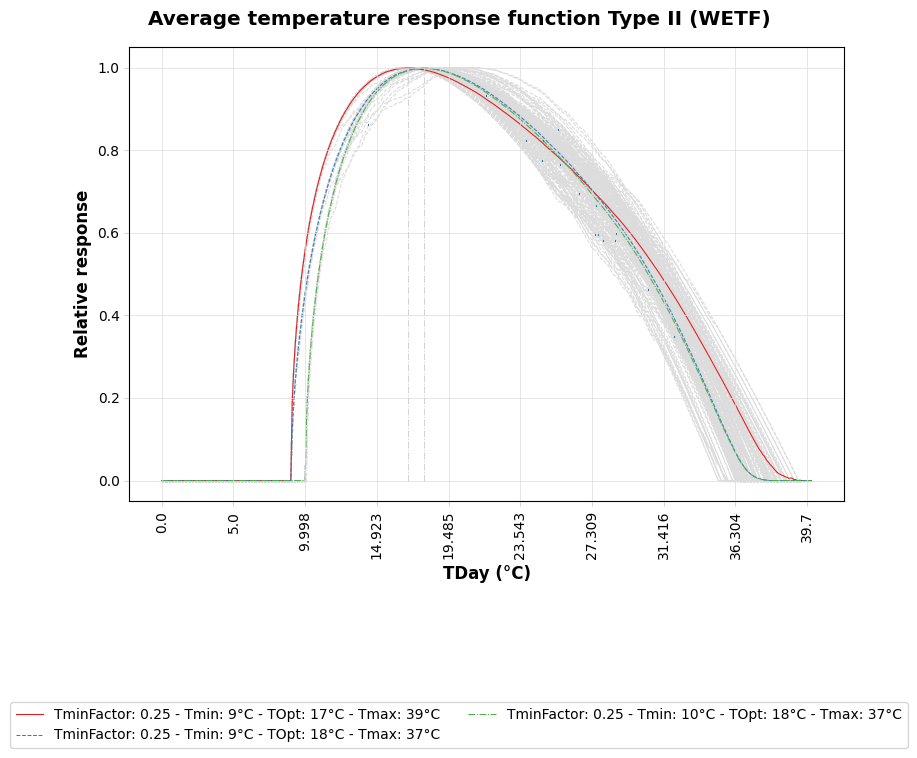

In [26]:
%%time
figures.diplay_Figure_Type_II_WETF_InOneFig(cmb=filtered_c_WETF, fnct='WETF', 
                                           df_tdays=df_TDays_vs_TempResponse, 
                                           df_tdays_mean=df_TDays_vs_TempResponse_mean_allSites,
                                           saveFig=True,showFig=True, fmt='jpg', leg_ncol=2,
                                           path_to_save_results=path_to_save_results)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:54<00:00,  5.46s/it]


CPU times: user 1min 2s, sys: 2.47 s, total: 1min 5s
Wall time: 1min 7s


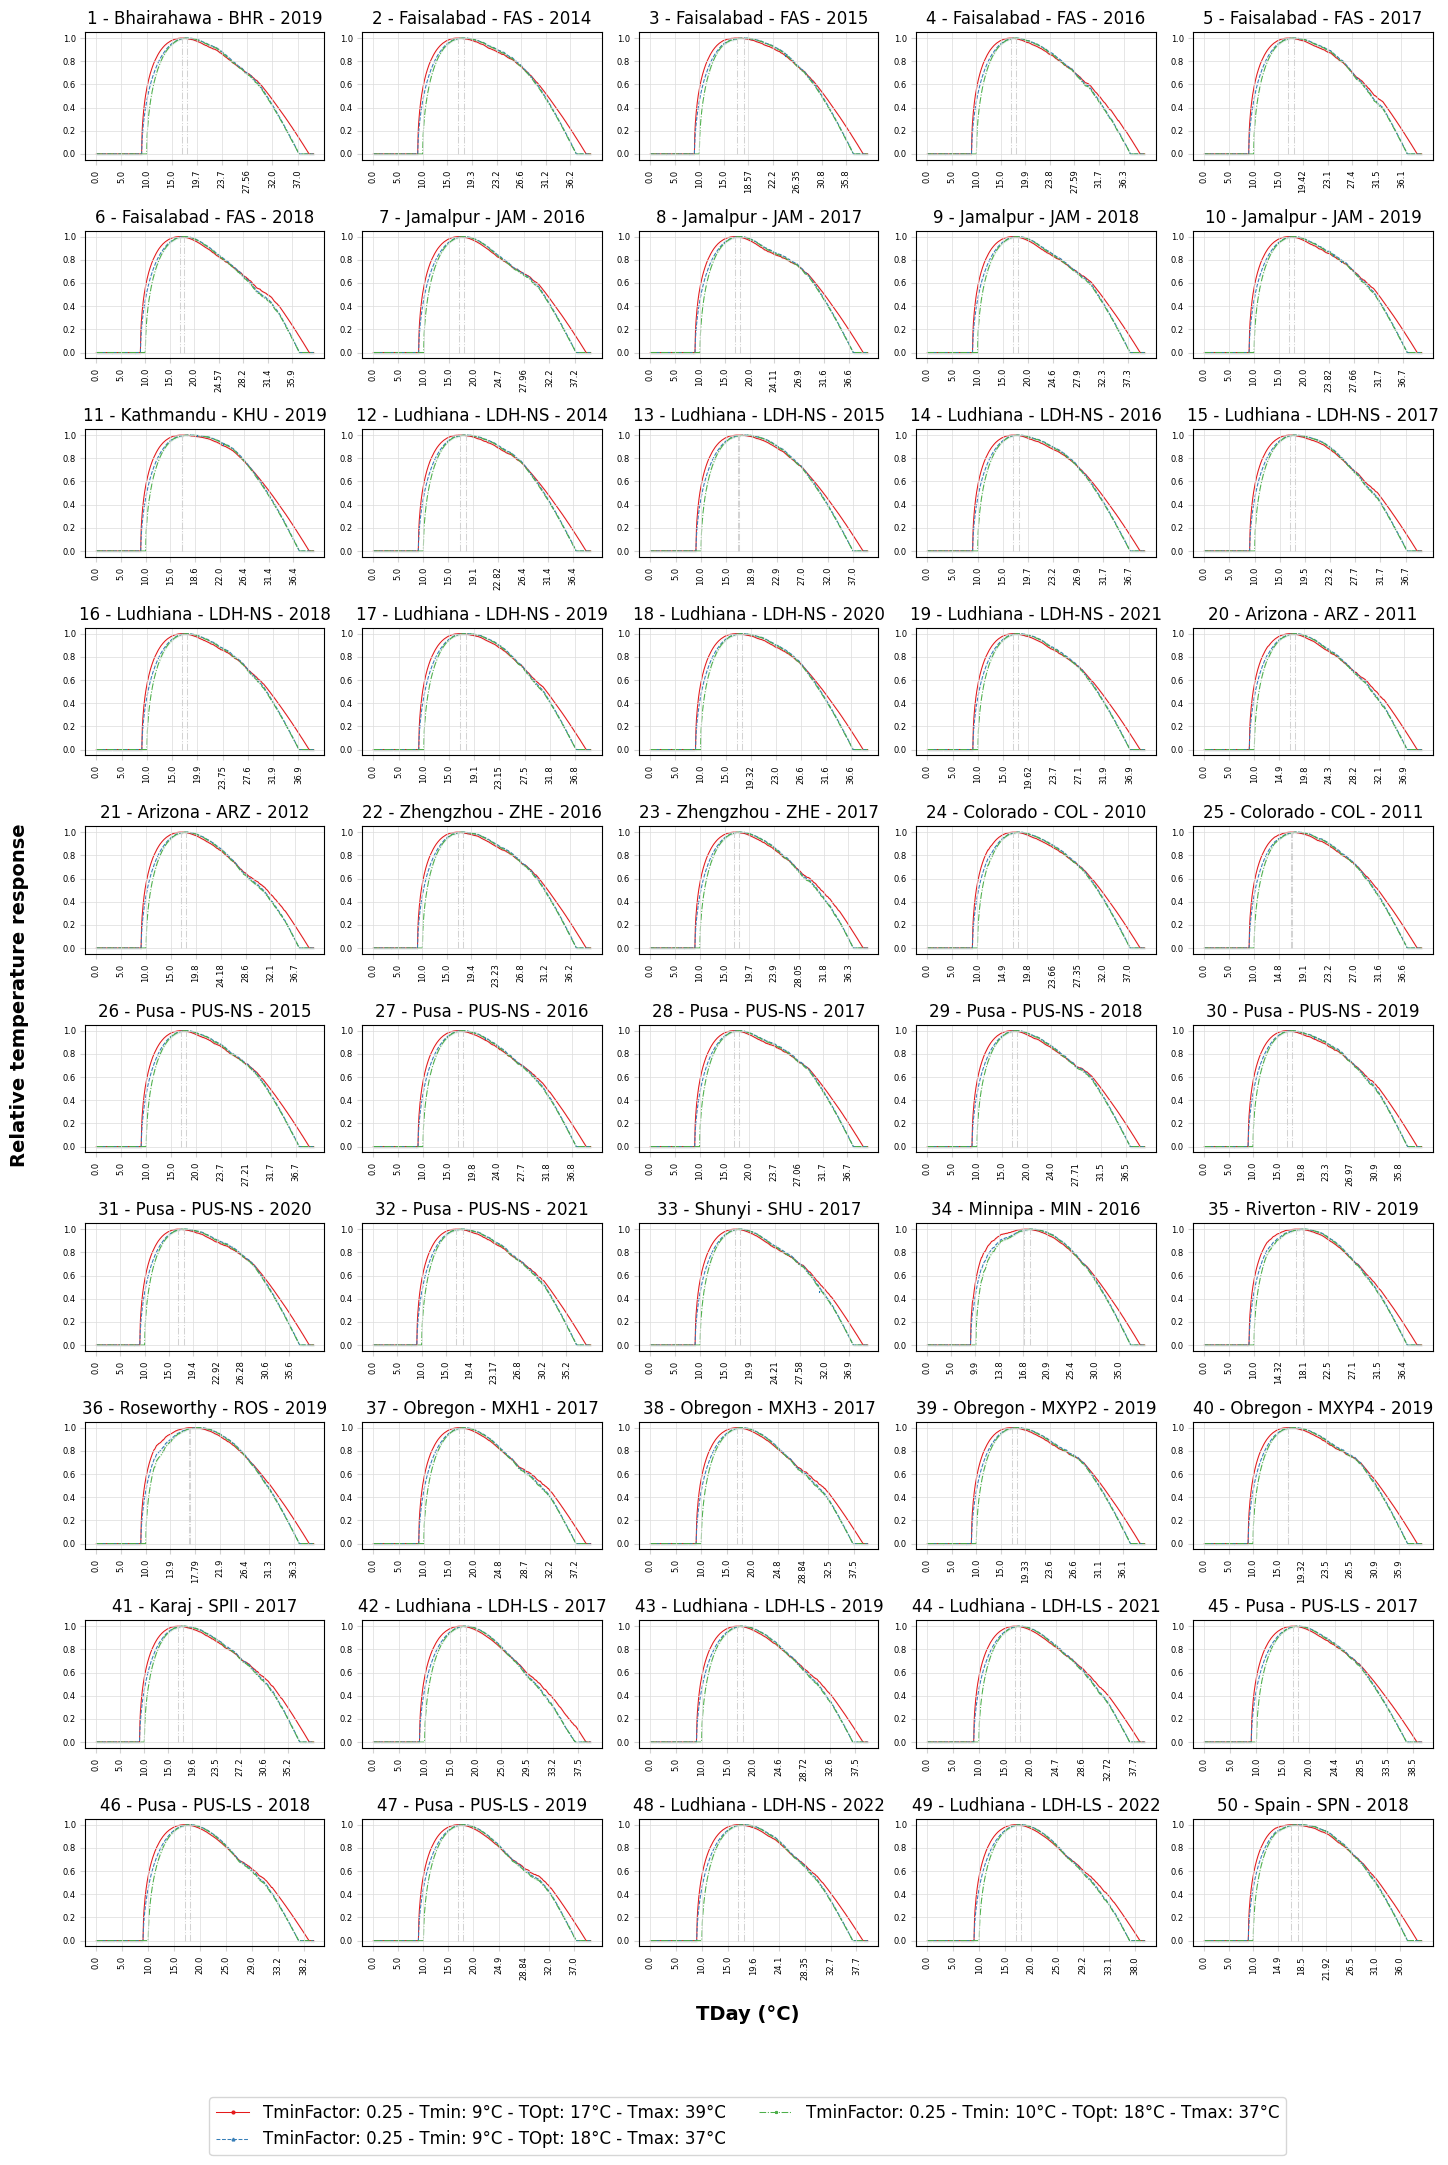

In [27]:
%%time
#cmb = [cmb_WETF_noStress['UID']==uid].reset_index(drop=True)
figures.display_FigTDay_vs_TempResponseBySiteYrs_WETF(cmb=filtered_c_WETF, df_tdays=df_TDays_vs_TempResponse, 
                                         roundVal=2, maxTDay=40, fnct='WETF', 
                                         saveFig=True, showFig=True, fmt='jpg', cols=5, leg_ncol=2,
                                         path_to_save_results=path_to_save_results)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.12it/s]


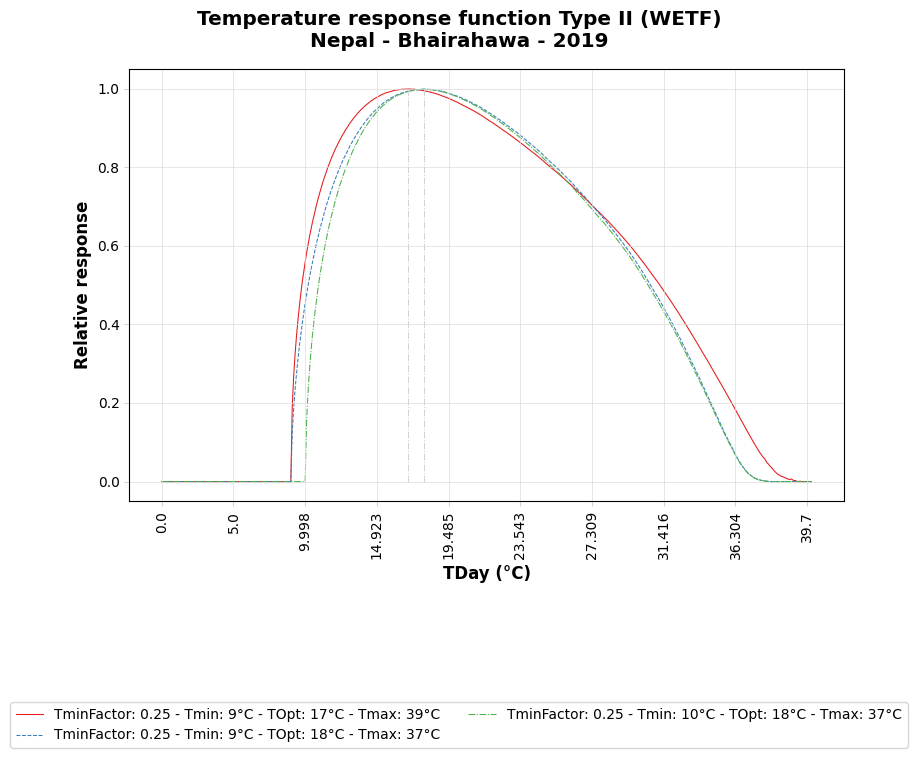

In [28]:
uid = 1
df0 = filtered_c_WETF[filtered_c_WETF['UID']==uid].reset_index(drop=True)
figures.diplay_Figure_Type_II_WETF_InOneFig(cmb=df0, fnct='WETF', 
                                           df_tdays=df_TDays_vs_TempResponse, 
                                           df_tdays_mean=df_TDays_vs_TempResponse_mean_allSites,
                                           saveFig=True,showFig=True, fmt='jpg', leg_ncol=2,
                                           path_to_save_results=path_to_save_results) #fname = "Figure_WETF_SiteYrs_Comparison" 

## Conclusion

Congratulations! You have run a simulation using a prebuilt dataset and the Temperature Functions API.


### Type 2- Three cardinal temperatures

|Model Parameters  | No stress  |  VPD stress |
|---|---|---| 
|RUE|3.0|3.0|
|TminFactor|0.25|0.25|
|Tmin|9-10 °C|6-10 °C|
|Topt|17-18 °C|19 °C|
|Tmax|37-39 °C|41-44 °C|
|SFvpdL||0.8|
|SFvpdU||1|
|VPDL||3 kPa|
|VPDU||3.5 kPa|


In [29]:
print(filtered_c_WETF['Tmin'].sort_values().unique())
print(filtered_c_WETF['Topt'].sort_values().unique())
print(filtered_c_WETF['Tmax'].sort_values().unique())
print(filtered_c_WETF_SFvpd['Tmin'].sort_values().unique())
print(filtered_c_WETF_SFvpd['Topt'].sort_values().unique())
print(filtered_c_WETF_SFvpd['Tmax'].sort_values().unique())
print(filtered_c_WETF_SFvpd['Lvpd'].sort_values().unique())
print(filtered_c_WETF_SFvpd['Uvpd'].sort_values().unique())
print(filtered_c_WETF_SFvpd['SFvpd_Lthres'].sort_values().unique())
print(filtered_c_WETF_SFvpd['SFvpd_Uthres'].sort_values().unique())

[ 9. 10.]
[17. 18.]
[37. 39.]
[ 6.  9. 10.]
[19.]
[41. 43. 44.]
[3.]
[3.5]
[0.8]
[1.]
